In [3]:
import numpy as np
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import xarray as xr
import xgcm
import gsw
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
plt.rcParams['font.size']=14

In [4]:
#constants through out this notebook
# derive the thermal wind based on a linear EOS
g=9.81
f=gsw.f(-65) 
alpha0=1e-4
rho0=1035

# Temperature structure

In [50]:
ds=xr.open_dataset('/home/birte/Maud12_sensitivityruns/EXP_REF_intel/ymonmean2.nc')
ds=ds.mean(dim="month")
dsu=xr.open_dataset('/home/birte/Maud12_sensitivityruns/EXP_REF_intel/annualmean_u_ontpoint.nc')
dsu=dsu.mean(dim="year").rename_dims({'x':'x_grid_T','y':'y_grid_T','z':'deptht'})
ds=xr.merge((ds,dsu))
ds=ds.isel(y_grid_T=slice(60,None,None)) # with this the continent is cut off
ds

<xarray.Dataset>
Dimensions:         (bnds: 2, deptht: 50, x_grid_T: 295, y_grid_T: 210)
Coordinates:
  * deptht          (deptht) float64 0.5002 1.547 2.651 ... 5.274e+03 5.728e+03
    nav_lon_grid_T  (y_grid_T, x_grid_T) float32 ...
    nav_lat_grid_T  (y_grid_T, x_grid_T) float32 ...
    x               (x_grid_T) int64 0 1 2 3 4 5 6 ... 289 290 291 292 293 294
    y               (y_grid_T) int64 60 61 62 63 64 65 ... 265 266 267 268 269
    z               (deptht) int64 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49
    lat             (y_grid_T, x_grid_T) float64 ...
    lon             (y_grid_T, x_grid_T) float64 ...
    depth           (deptht) float32 ...
Dimensions without coordinates: bnds, x_grid_T, y_grid_T
Data variables: (12/21)
    deptht_bnds     (deptht, bnds) float32 0.0 1.022 1.022 ... 5.5e+03 5.958e+03
    e3t             (deptht, y_grid_T, x_grid_T) float32 nan 1.022 ... nan nan
    zos             (y_grid_T, x_grid_T) float32 nan -1.713 -1.713 ... nan nan
    thetao          (deptht, y_grid_T, x_grid_T) float32 nan -1.575 ... nan nan
    so              (deptht, y_grid_T, x_grid_T) float32 nan 34.16 ... nan nan
    mldkz5          (y_grid_T, x_grid_T) float32 nan 52.67 53.3 ... nan nan nan
    ...              ...
    sfx             (y_grid_T, x_grid_T) float32 nan 0.00168 ... nan nan
    taum            (y_grid_T, x_grid_T) float32 nan 0.06142 0.09947 ... nan nan
    windsp          (y_grid_T, x_grid_T) float32 nan 7.733 7.733 ... nan nan nan
    precip          (y_grid_T, x_grid_T) float32 nan 1.447e-05 ... nan nan
    snowpre         (y_grid_T, x_grid_T) float32 nan 1.4e-05 ... nan nan
    uont_an         (deptht, y_grid_T, x_grid_T) float32 0.0 -0.03485 ... nan

In [61]:
dsr.nav_lat_grid_T.values

array([-68.79262543, -68.60526676, -68.41790809, -68.23054942,
       -68.04319076, -67.85583209, -67.66847342, -67.48111475,
       -67.29375608, -67.10639742, -66.91903875, -66.73168008,
       -66.54432141, -66.35696274, -66.16960408, -65.98224541,
       -65.79488674, -65.60752807, -65.42016941, -65.23281074,
       -65.04545207, -64.8580934 , -64.67073473, -64.48337607,
       -64.2960174 , -64.10865873, -63.92130006, -63.73394139,
       -63.54658273, -63.35922406, -63.17186539, -62.98450672,
       -62.79714805, -62.60978939, -62.42243072, -62.23507205,
       -62.04771338, -61.86035471, -61.67299605,          nan])

In [51]:
#convert lon lat to distance
dist_x=gsw.distance(ds.nav_lon_grid_T.isel(y_grid_T=190).values,ds.nav_lat_grid_T.isel(y_grid_T=190).values)
cumdist_x=np.zeros(295)
cumdist_x[1:]=dist_x.cumsum()


dist_y=gsw.distance(ds.nav_lon_grid_T.isel(x_grid_T=92).values,ds.nav_lat_grid_T.isel(x_grid_T=92).values)
cumdist_y=np.zeros(210)
cumdist_y[1:]=dist_y.cumsum()#+0.4e6
ds.coords['cumdist_x']=ds.x_grid_T*0+cumdist_x
ds.coords['cumdist_y']=ds.y_grid_T*0+cumdist_y

In [52]:
# MITgcm grid

# horizontal grid cells
nx = 60
ny = 40

# choose vertical resolution
dr=np.array(50*np.ones(100))
nr = len(dr)
rF = (np.insert(np.cumsum(dr),0,0)) # z-coordinates of vertical cell faces
z = np.diff(rF)/2 + rF[:-1]         # z-coordinates of vertical cell centers
H = -np.sum(dr)  
print(H)
# horizontal resoluiton in km 25
dx=25
dy=25
X=np.arange(0,nx*dx,dx)
Y=np.arange(0,ny*dx,dy)

-5000.0


In [53]:
# replace x indx by distance so I can interpolate
ds['x_grid_T']=ds.cumdist_x
ds['y_grid_T']=ds.cumdist_y*1.2 # add 1-3 to strech to model output to fit mitgcm dimesions
dsi=ds.interp(x_grid_T=X*10e2,y_grid_T=Y*10e2,deptht=z)
dsi

<xarray.Dataset>
Dimensions:         (bnds: 2, deptht: 100, x_grid_T: 60, y_grid_T: 40)
Coordinates: (12/13)
    nav_lon_grid_T  (y_grid_T, x_grid_T) float64 -5.083 -4.6 -4.117 ... nan nan
    nav_lat_grid_T  (y_grid_T, x_grid_T) float64 -68.79 -68.79 ... nan nan
    x               (x_grid_T) float64 0.0 5.799 11.6 17.4 ... nan nan nan nan
    y               (y_grid_T) float64 60.0 66.19 72.33 ... 260.6 265.3 nan
    z               (deptht) float64 12.95 19.77 22.74 ... 47.1 47.21 47.32
    lat             (y_grid_T, x_grid_T) float64 -68.79 -68.79 ... nan nan
    ...              ...
    depth           (deptht) float64 25.0 75.0 125.0 ... 4.925e+03 4.975e+03
    cumdist_x       (x_grid_T) float64 0.0 2.5e+04 5e+04 7.5e+04 ... nan nan nan
    cumdist_y       (y_grid_T) float64 0.0 2.083e+04 4.167e+04 ... 7.917e+05 nan
  * x_grid_T        (x_grid_T) float64 0.0 2.5e+04 5e+04 ... 1.45e+06 1.475e+06
  * y_grid_T        (y_grid_T) float64 0.0 2.5e+04 5e+04 ... 9.5e+05 9.75e+05
  * deptht          (deptht) float64 25.0 75.0 125.0 ... 4.925e+03 4.975e+03
Dimensions without coordinates: bnds
Data variables: (12/21)
    deptht_bnds     (deptht, bnds) float64 23.15 27.02 ... 4.757e+03 5.196e+03
    e3t             (deptht, y_grid_T, x_grid_T) float64 nan 3.87 ... nan nan
    zos             (y_grid_T, x_grid_T) float64 nan -1.714 -1.719 ... nan nan
    thetao          (deptht, y_grid_T, x_grid_T) float64 nan -1.657 ... nan nan
    so              (deptht, y_grid_T, x_grid_T) float64 nan 34.19 ... nan nan
    mldkz5          (y_grid_T, x_grid_T) float64 nan 57.77 62.31 ... nan nan nan
    ...              ...
    sfx             (y_grid_T, x_grid_T) float64 nan 0.0003085 ... nan nan
    taum            (y_grid_T, x_grid_T) float64 nan 0.09977 0.09816 ... nan nan
    windsp          (y_grid_T, x_grid_T) float64 nan 7.736 7.741 ... nan nan nan
    precip          (y_grid_T, x_grid_T) float64 nan 1.452e-05 ... nan nan
    snowpre         (y_grid_T, x_grid_T) float64 nan 1.406e-05 ... nan nan
    uont_an         (deptht, y_grid_T, x_grid_T) float64 0.0 -0.05938 ... nan

/home/birte/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


(0.0, 1200000.0)

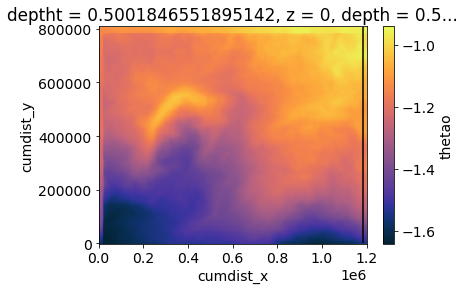

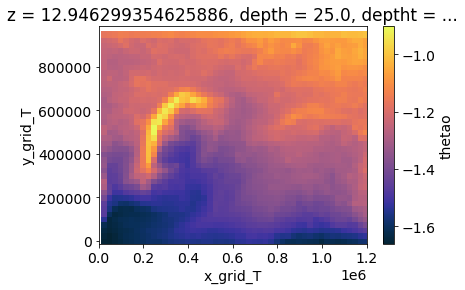

In [54]:
plt.figure()
ds.thetao.isel(deptht=0).plot.pcolormesh(x="cumdist_x",y="cumdist_y",cmap=cmo.thermal)
plt.vlines(x=ds.cumdist_x.isel(x_grid_T=275),ymin=ds.cumdist_y.isel(y_grid_T=0),ymax=ds.cumdist_y.isel(y_grid_T=-1),colors='k')
plt.xlim(0,1.2e6)
plt.figure()
dsi.thetao.isel(deptht=0).plot.pcolormesh(cmap=cmo.thermal)
plt.vlines(x=dsi.cumdist_x.isel(x_grid_T=44),ymin=dsi.cumdist_y.isel(y_grid_T=0),ymax=dsi.cumdist_y.isel(y_grid_T=-1),colors='k')
plt.xlim(0,1.2e6)

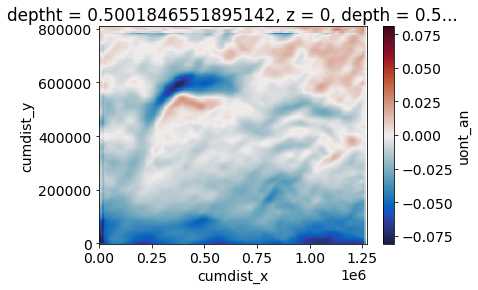

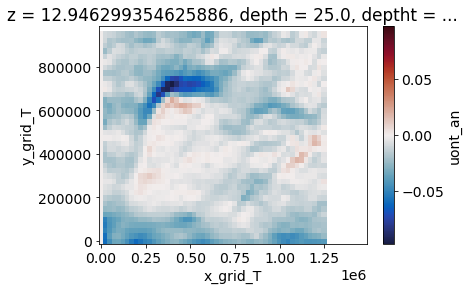

In [55]:
plt.figure()
ds.uont_an.isel(deptht=0).plot.pcolormesh(x="cumdist_x",y="cumdist_y",cmap=cmo.balance)

plt.figure()
dsi.uont_an.isel(deptht=0).plot.pcolormesh(cmap=cmo.balance)
plt.vlines(x=dsi.cumdist_x.isel(x_grid_T=43),ymin=dsi.cumdist_y.isel(y_grid_T=0),ymax=dsi.cumdist_y.isel(y_grid_T=-1),colors='k')

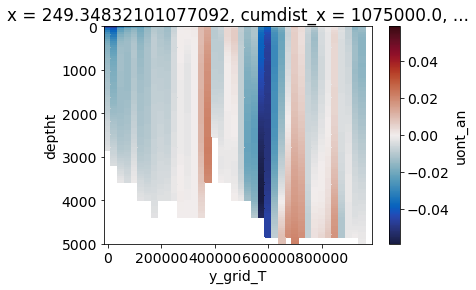

In [56]:
# Reduce data set to one section (as indicated in the plot above)
dsr=dsi.isel(x_grid_T=43)
dsr.uont_an.plot.pcolormesh(cmap=cmo.balance)
plt.gca().invert_yaxis()

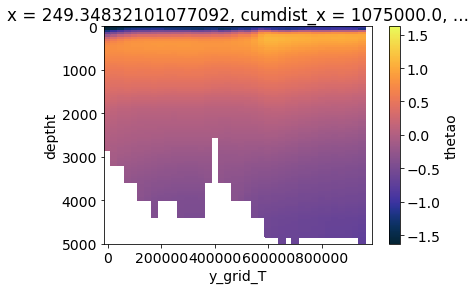

In [57]:
dsr.thetao.plot.pcolormesh(cmap=cmo.thermal)
plt.gca().invert_yaxis()

Text(0.5, 1.0, 'Original- density section')

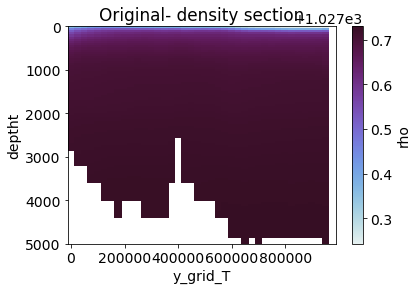

In [58]:
# convert the maud12 section in to density and then back to an equivalent temperature section
#p=gsw.p_from_z(-1*dsr.deptht,-65)
dsr["rho"]=gsw.rho(dsr.so,dsr.thetao,0)
plt.figure()
dsr.rho.plot.pcolormesh(cmap=cmo.dense)
plt.gca().invert_yaxis()
plt.title('Original- density section')


In [30]:
CT=gsw.CT_from_rho(dsr.rho, 35,0)
T_equi=CT[0]
T_mult=CT[1]


In [31]:
T_int=dsr.thetao*np.nan
S_int=dsr.so*np.nan
T_int.shape

for kk in range(0,100):
    tt=dsr.thetao.isel(deptht=kk)
    ss=dsr.so.isel(deptht=kk)
    a=np.where(~np.isnan(tt))[0]
    #print(a[0],a[-1])
    if a[-1]==39:
        tt=xr.where(~np.isnan(tt),
        tt,
        tt.isel(y_grid_T=a[0]))
        ss=xr.where(~np.isnan(ss),
        ss,
        ss.isel(y_grid_T=a[0]))
    else:
        tt[:a[-1]]=xr.where(~np.isnan(tt.isel(y_grid_T=slice(0,a[-1]))),
        tt.isel(y_grid_T=slice(0,a[-1])),
        tt.isel(y_grid_T=a[0]))    
        tt[a[-1]:]=xr.where(~np.isnan(tt.isel(y_grid_T=slice(a[-1],None,None))),
        tt.isel(y_grid_T=slice(a[-1],None,None)),
        tt.isel(y_grid_T=a[-1]))  
        ss[:a[-1]]=xr.where(~np.isnan(ss.isel(y_grid_T=slice(0,a[-1]))),
        ss.isel(y_grid_T=slice(0,a[-1])),
        ss.isel(y_grid_T=a[0]))    
        ss[a[-1]:]=xr.where(~np.isnan(ss.isel(y_grid_T=slice(a[-1],None,None))),
        ss.isel(y_grid_T=slice(a[-1],None,None)),
        ss.isel(y_grid_T=a[-1]))  
    T_int[kk,:]=tt
    S_int[kk,:]=ss

T_3Di=np.zeros((nr,ny,nx))
for i in range(0,nx):
    T_3Di[:,:,i]=T_int

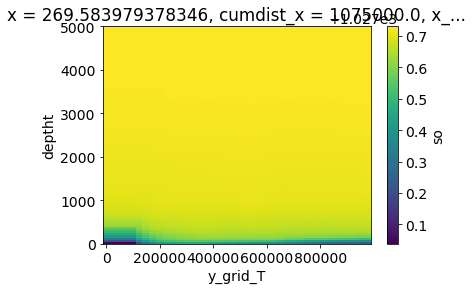

In [32]:
rho_int=gsw.rho(S_int,T_int,0)
rho_int.plot.pcolormesh()

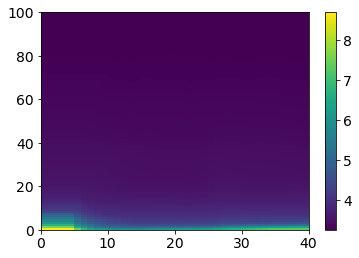

In [55]:
T_equi_int=gsw.CT_from_rho(rho_int,35,0)
plt.pcolormesh(T_equi_int[0])
plt.colorbar()

In [57]:
#(60, 100, 40) obcs
T_3Dobcs=np.zeros((nx,nr,ny))
for i in range(0,nx):
    T_3Dobcs[i,:,:]=T_equi_int[0]

In [12]:
T_3Di.astype('>f4').tofile(f'T5000_ini_realistic_{len(dr)}_25km.bin')
T_3Dobcs.astype('>f4').tofile(f'T5000_obcs_realistic_{len(dr)}_25km.bin')

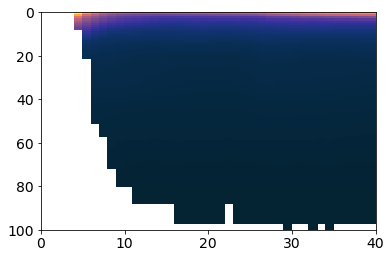

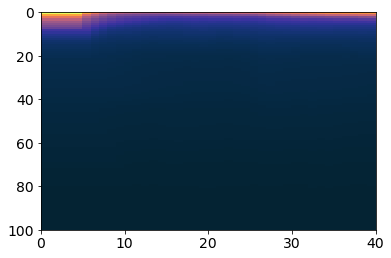

In [63]:
plt.figure()
plt.pcolormesh(T_equi,cmap=cmo.thermal)
plt.gca().invert_yaxis()

plt.figure()
plt.pcolormesh(T_3Dobcs[35,:,:],cmap=cmo.thermal)
plt.gca().invert_yaxis()

<xarray.DataArray 'U_from_T' ()>
array(0.00268664)
Coordinates:
    x        int64 59
(60, 100, 40)


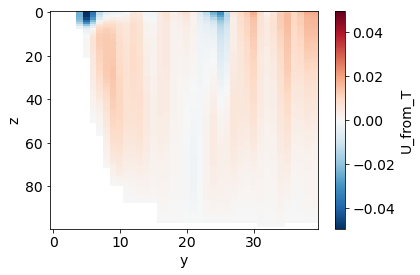

In [64]:
# derive the thermal wind based on a linear EOS

rho=rho0- rho0*alpha0*T_3Di

dsm = xr.Dataset()
dsm['rho'] = (('z', 'y', 'x'), rho)
dsm = dsm.assign_coords(x=dsm.x, y=dsm.y, z=dsm.z)
dsm.x.attrs['axis'] = 'X'
dsm.y.attrs['axis'] = 'Y'
dsm.z.attrs['axis'] = 'Z'
dsm = xgcm.generate_grid_ds(dsm, {'X':'x', 'Y':'y', 'Z':'z'})
grid = xgcm.Grid(dsm, periodic=False)
dsm['dr'] = ('z', dr)
dsm["T_3D"]=(('z', 'y', 'x'),T_3Di)
rev = -1*(g/f)*grid.cumsum(
    (
        grid.interp(1/dsm.rho, 'Y', boundary='extend') * grid.diff(dsm.rho, 'Y', boundary='extend') / (dy*10**3)
    ) * dsm.dr,
    'Z',
    boundary='fill',
    fill_value=0
)
velocity = rev.isel(z_left=-1) - rev
dsm['U_from_T'] = grid.interp(velocity, ['Y', 'Z'], boundary='extend')
dsm.U_from_T.where(dsm.U_from_T!=0).mean('x').plot(y='z', yincrease=False)
print(dsm.U_from_T.isel(x=59).mean(dim={'y','z'}))

U_tw=np.asarray(dsm.U_from_T.transpose("x", "z", "y"))
print(U_tw.shape)

U_tw.astype('>f4').tofile(f'Uvel5000_tw_realistic_xzy_{len(dr)}_25km.bin') # I assume the x dimension is read as t dimension 

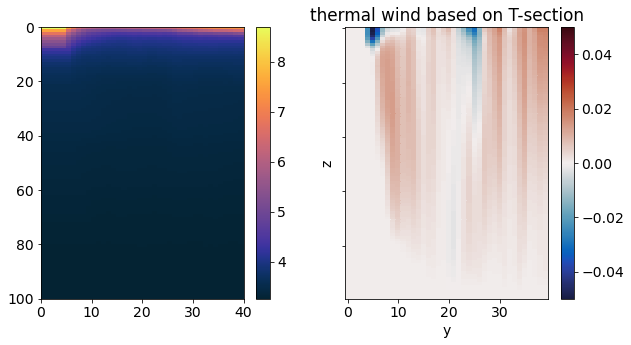

In [65]:
fig,axes=plt.subplots(1,2,figsize=(10,5))
ax=axes[0]
#cbt=T_int.plot.pcolormesh(x="y",y="z",vmin=-1.5,vmax=1.5,cmap=cmo.thermal,ax=ax,add_colorbar=False)
cbt=ax.pcolormesh(T_3Dobcs[35,:,:],cmap=cmo.thermal)
#dsm.rho.isel(x=35).plot.contour(x="y",y="z",ax=ax)
ax.invert_yaxis()
plt.colorbar(cbt,ax=ax)

ax=axes[1]
cbu=dsm.U_from_T.isel(x=35).plot.pcolormesh(x="y",y="z",vmin=-0.05,vmax=0.05,cmap=cmo.balance,ax=ax,add_colorbar=False)
ax.invert_yaxis()
ax.set_yticklabels('')
ax.set_title('thermal wind based on T-section')
plt.colorbar(cbu,ax=ax)


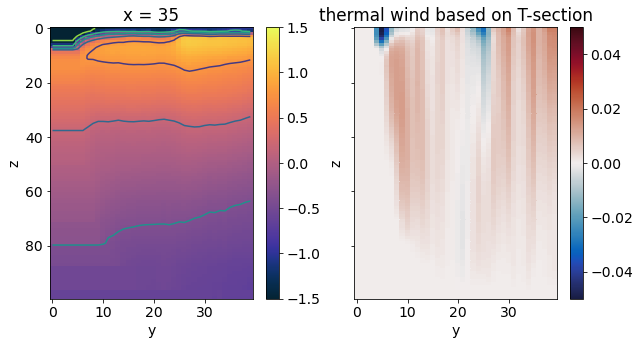

In [24]:
fig,axes=plt.subplots(1,2,figsize=(10,5))
ax=axes[0]
cbt=dsm.T_3D.isel(x=35).plot.pcolormesh(x="y",y="z",vmin=-1.5,vmax=1.5,cmap=cmo.thermal,ax=ax,add_colorbar=False)
dsm.rho.isel(x=35).plot.contour(x="y",y="z",ax=ax)
ax.invert_yaxis()
plt.colorbar(cbt,ax=ax)

ax=axes[1]
cbu=dsm.U_from_T.isel(x=35).plot.pcolormesh(x="y",y="z",vmin=-0.05,vmax=0.05,cmap=cmo.balance,ax=ax,add_colorbar=False)
ax.invert_yaxis()
ax.set_yticklabels('')
ax.set_title('thermal wind based on T-section')
plt.colorbar(cbu,ax=ax)


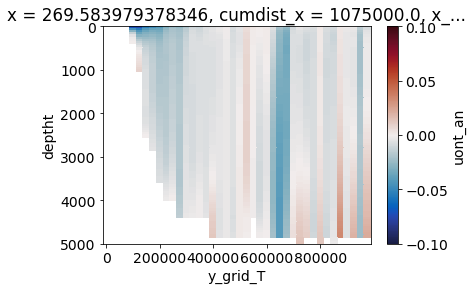

In [16]:
# model mean u
dsr.uont_an.plot.pcolormesh(vmin=-0.1,vmax=0.1,cmap=cmo.balance)
plt.gca().invert_yaxis()

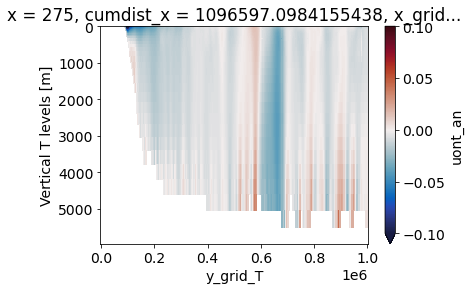

In [42]:
ds.uont_an.isel(x_grid_T=275).plot.pcolormesh(vmin=-0.1,vmax=0.1,cmap=cmo.balance)
plt.gca().invert_yaxis()

-0.010332703138731417

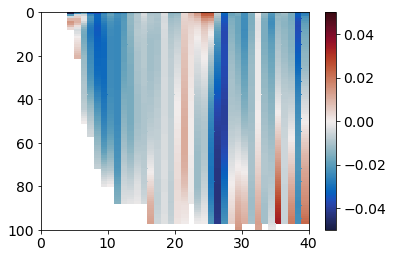

In [17]:
# u_baro= (u_model mean - u-from T) mean along (y,z)
u=dsr.uont_an.data-dsm.U_from_T.isel(x=1).T.data


plt.figure()
plt.pcolormesh(u[:,:],vmin=-0.05,vmax=0.05,cmap=cmo.balance)
plt.gca().invert_yaxis()
plt.colorbar()

u_baro=np.nanmean(u)
u_baro

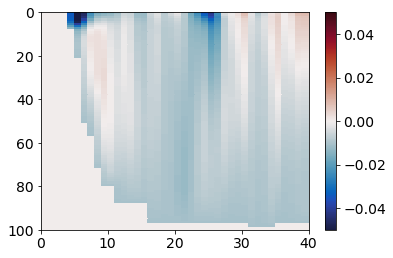

In [18]:
#u_model=U_tw[35,:,:]*0
u_model=dsm.U_from_T.where(dsm.U_from_T!=0, other=-u_baro).isel(x=35)+u_baro
#u_model=dsm.U_from_T.isel(x=35)+u_baro
plt.pcolormesh(u_model[:,:].T,vmin=-0.05,vmax=0.05,cmap=cmo.balance)
plt.gca().invert_yaxis()
plt.colorbar()

In [20]:
print(u_model.mean())
print(dsr.uont_an.fillna(0).mean())

<xarray.DataArray 'U_from_T' ()>
array(-0.00543745)
Coordinates:
    x        int64 35
<xarray.DataArray 'uont_an' ()>
array(-0.00541684)
Coordinates:
    x          float64 269.6
    cumdist_x  float64 1.075e+06
    x_grid_T   float64 1.075e+06


In [21]:
u_mod_3D=np.zeros(T_3Dobcs.shape)
u_mod_3D.shape
for j in range(0,nx):
    u_mod_3D[j,:,:]=u_model.T

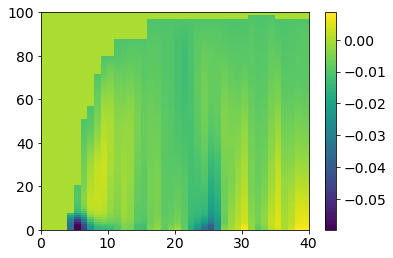

In [22]:
plt.pcolormesh(u_mod_3D[35,:,:])
plt.colorbar()

In [44]:
print(u_mod_3D.shape)
#U_tw=np./proj/climategu/users/x_birgu/MITgcm/verification/TC_runs_100vl_dx25km/run_bump5000_real_utw
#u_mod_3D.astype('>f4').tofile(f'Uvel5000_utw_realistic_xzy_{len(dr)}_25km.bin') # I assume the x dimension is read as t dimension 

(60, 100, 40)


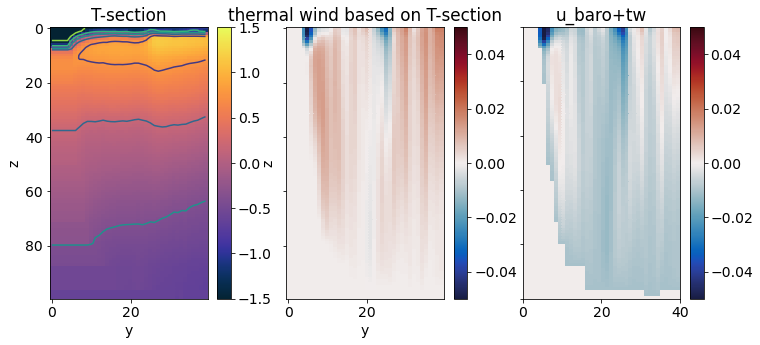

In [51]:
fig,axes=plt.subplots(1,3,figsize=(12,5))
ax=axes[0]
cbt=dsm.T_3D.isel(x=35).plot.pcolormesh(x="y",y="z",vmin=-1.5,vmax=1.5,cmap=cmo.thermal,ax=ax,add_colorbar=False)
dsm.rho.isel(x=35).plot.contour(x="y",y="z",ax=ax)
ax.invert_yaxis()
ax.set_title('T-section')
plt.colorbar(cbt,ax=ax)

ax=axes[1]
cbu=dsm.U_from_T.isel(x=35).plot.pcolormesh(x="y",y="z",vmin=-0.05,vmax=0.05,cmap=cmo.balance,ax=ax,add_colorbar=False)
ax.invert_yaxis()
ax.set_yticklabels('')
ax.set_title('thermal wind based on T-section')
plt.colorbar(cbu,ax=ax)

ax=axes[2]
cbu=ax.pcolormesh(u_mod_3D[35,:,:],vmin=-0.05,vmax=0.05,cmap=cmo.balance)
ax.invert_yaxis()
ax.set_yticklabels('')
ax.set_title('u_baro+tw')
plt.colorbar(cbu,ax=ax)


# Baroclinic and Barotropic mean velocities; and mean density profile

In [2]:
dst=xr.open_dataset('./NEMO_output/T_S_mean_domain.nc')
dsu=xr.open_dataset('./NEMO_output/ubaro_components.nc')

In [4]:
dst

<xarray.Dataset>
Dimensions:  (z: 50)
Coordinates:
  * z        (z) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
    depth    (z) float32 ...
Data variables:
    T_mean   (z) float64 ...
    S_mean   (z) float64 ...

(0.0, 1.0, 0.0, 1.0)

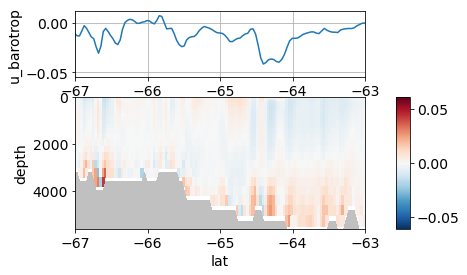

In [8]:
fig,axes=plt.subplots(2,2,gridspec_kw={'height_ratios':[.5,1],'width_ratios':[1,0.05]})

dsu.u_barotrop.plot(x="lat",ax=axes[0,0])
axes[0,0].grid()
axes[0,0].set_xlim(-67,-63)


cbu=dsu.u_baroclin.plot.pcolormesh(x="lat",y="depth",ax=axes[1,0],add_colorbar=False)
dsu.u_baroclin.fillna(-2).where(dsu.u_baroclin.fillna(-100)==-100).plot.contourf(x="lat",y="depth",colors='silver',ax=axes[1,0],add_colorbar=False)
axes[1,0].invert_yaxis()
plt.colorbar(cbu,cax=axes[1,1])
axes[1,0].set_xlim(-67,-63)
axes[1,0].set_ylim(5600,0)
axes[0,1].axis('off')

In [9]:
dst['rho_mean']=gsw.rho(dst.S_mean,dst.T_mean,gsw.p_from_z(-1*dst.z,-65))
dst['sigma0_mean']=gsw.sigma0(dst.S_mean,dst.T_mean)

Text(0.5, 1.0, '$\\rho$')

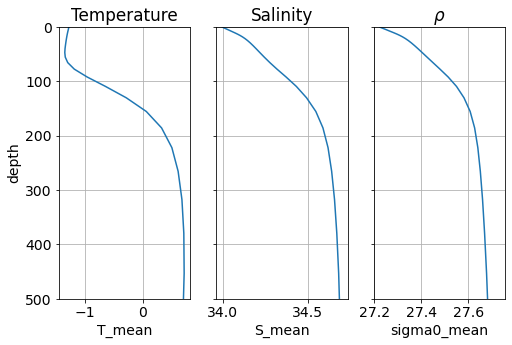

In [10]:
fig,axes=plt.subplots(1,3,figsize=(8,5))
dst.T_mean.plot(y="depth",ax=axes[0])
axes[0].set_ylim(0,500)
axes[0].invert_yaxis()
axes[0].grid()
axes[0].set_title('Temperature')

dst.S_mean.plot(y="depth",ax=axes[1])
axes[1].set_ylim(0,500)
axes[1].invert_yaxis()
axes[1].grid()
axes[1].set_ylabel('')
axes[1].set_yticklabels('')
axes[1].set_title('Salinity')

dst.sigma0_mean.plot(y="depth",ax=axes[2])
axes[2].set_ylim(0,500)
axes[2].invert_yaxis()
axes[2].grid()
axes[2].set_ylabel('')
axes[2].set_yticklabels('')
axes[2].set_title('$\\rho$')

# Compare Bathymetry

In [1]:
def fix_dimension(ds, bad_dim, new_dim, trim=True):
    assert len(ds[bad_dim]) == (len(ds[new_dim]) + 1)
    if trim and (len(ds[bad_dim]) == (len(ds[new_dim]) + 1)):
        ds = ds.isel(**{bad_dim: slice(0,-1)})
        assert len(ds[bad_dim]) == len(ds[new_dim])
    swapped_vars = []
    for v in ds:
        # replace naughty dimension
        dims = list(ds[v].dims)
        if bad_dim in dims:
            idx = dims.index(bad_dim)
            dims[idx] = new_dim
            ds[v].variable.dims = dims
            swapped_vars.append(v)
    return ds, swapped_vars

def reset_dimensions(ds, orig_dim, new_dim, *reset_vars):
    for v in reset_vars:
        dims = list(ds[v].dims)
        if new_dim in dims:
            idx = dims.index(new_dim)
            dims[idx] = orig_dim
            ds[v].variable.dims = dims
    # reindexing necessary to figure out new dims
    return ds.reindex()

def open_mncdataset(fname_base, ntiles_y, ntiles_x, iternum=None):
    if iternum is not None:
        itersuf = '.%010d' % iternum
    else:
        itersuf = ''
    dsets_y = []
    for ny in range(ntiles_y):
        dsets_x = []
        swap_vars = set()
        for nx in range(ntiles_x):
            ntile = nx + ntiles_x*ny + 1
            fname = fname_base + '%s.t%03d.nc' % (itersuf, ntile)
            ds = xr.open_dataset(fname)
            ds, swapped_vars_x = fix_dimension(ds, 'Xp1', 'X')    
            ds = ds.chunk()
            dsets_x.append(ds)
        ds_xconcat = xr.concat(dsets_x, 'X')
        ds_xconcat, swapped_vars_y = fix_dimension(ds_xconcat, 'Yp1', 'Y')
        dsets_y.append(ds_xconcat)
    ds = xr.concat(dsets_y, 'Y')
    ds = reset_dimensions(ds, 'Xp1', 'X', *swapped_vars_x)
    ds = reset_dimensions(ds, 'Yp1', 'Y', *swapped_vars_y)
    return ds



In [5]:
bat=xr.open_dataset('/home/birte/MAUD_RISE_config/maud_v4/m12_mask/1_domain_cfg_50levels_new.nc')
bat

<xarray.Dataset>
Dimensions:       (x: 295, y: 270, z: 50)
Dimensions without coordinates: x, y, z
Data variables: (12/41)
    nav_lon       (y, x) float32 ...
    nav_lat       (y, x) float32 ...
    nav_lev       (z) float32 ...
    jpiglo        int32 ...
    jpjglo        int32 ...
    jpkglo        int32 ...
    ...            ...
    e3f_0         (z, y, x) float64 ...
    e3uw_0        (z, y, x) float64 ...
    e3vw_0        (z, y, x) float64 ...
    bottom_level  (y, x) int32 ...
    top_level     (y, x) int32 ...
    bathy_meter   (y, x) float32 ...

In [6]:

dist_x=gsw.distance(bat.nav_lon.isel(y=190).values,bat.nav_lat.isel(y=190).values)
cumdist_x=np.zeros(295)
cumdist_x[1:]=dist_x.cumsum()+0.4e6


dist_y=gsw.distance(bat.nav_lon.isel(x=92).values,bat.nav_lat.isel(x=92).values)
cumdist_y=np.zeros(270)
cumdist_y[1:]=dist_y.cumsum()#+0.4e6

In [7]:
dsg = open_mncdataset('run_bump5000_barotrop/grid', 2, 3, None)

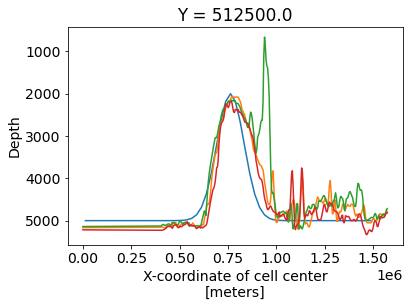

In [8]:
dsg.Depth.isel(Y=20).plot()
plt.plot(cumdist_x,bat.bathy_meter.isel(y=190))
plt.plot(cumdist_x,bat.bathy_meter.isel(y=185))
plt.plot(cumdist_x,bat.bathy_meter.isel(y=195))
plt.gca().invert_yaxis()

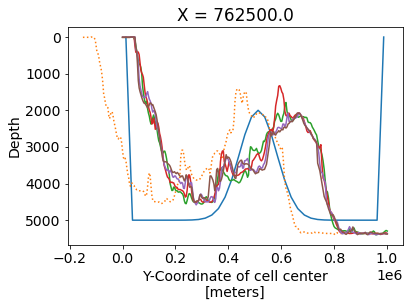

In [9]:
dsg.Depth.isel(X=30).plot()
plt.plot(cumdist_y-150000,bat.bathy_meter.isel(x=92),ls=':')
plt.plot(cumdist_y,bat.bathy_meter.isel(x=90))
plt.plot(cumdist_y,bat.bathy_meter.isel(x=94))
plt.plot(cumdist_y,bat.bathy_meter.isel(x=98))
plt.plot(cumdist_y,bat.bathy_meter.isel(x=100))

plt.gca().invert_yaxis()

In [10]:
bat.coords['cumdist_x']=bat.x*0+cumdist_x
bat.coords['cumdist_y']=bat.y*0+cumdist_y-150000
bat

<xarray.Dataset>
Dimensions:       (x: 295, y: 270, z: 50)
Coordinates:
    cumdist_x     (x) float64 0.0 4.04e+05 4.08e+05 ... 1.568e+06 1.572e+06
    cumdist_y     (y) float64 -1.5e+05 -1.469e+05 ... 8.466e+05 8.51e+05
Dimensions without coordinates: x, y, z
Data variables: (12/41)
    nav_lon       (y, x) float32 -5.083 -5.0 -4.917 -4.833 ... 19.25 19.33 19.42
    nav_lat       (y, x) float32 -70.53 -70.53 -70.53 ... -61.53 -61.53 -61.53
    nav_lev       (z) float32 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
    jpiglo        int32 295
    jpjglo        int32 270
    jpkglo        int32 50
    ...            ...
    e3f_0         (z, y, x) float64 ...
    e3uw_0        (z, y, x) float64 ...
    e3vw_0        (z, y, x) float64 ...
    bottom_level  (y, x) int32 0 0 0 0 0 0 0 0 0 ... 48 48 48 48 48 48 48 48 48
    top_level     (y, x) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1
    bathy_meter   (y, x) float32 7.168 7.168 7.168 ... 5.031e+03 5.051e+03

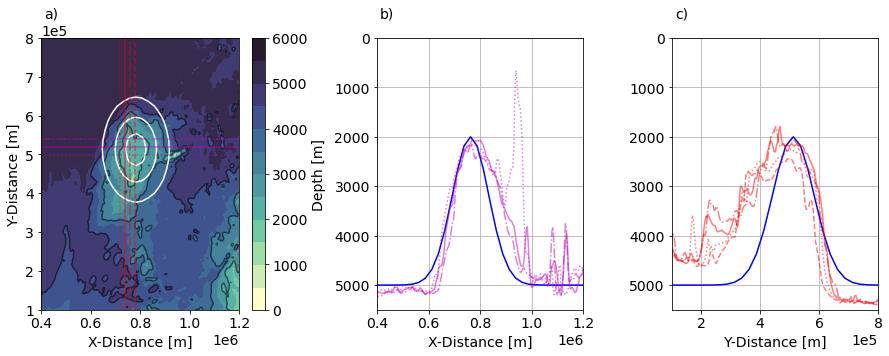

In [18]:
fig,axes=plt.subplots(1,3,figsize=(15,5),gridspec_kw={'width_ratios':[1.2,1,1],'wspace':.4})
ax=axes[0]
#cb=ax.contourf(bat.cumdist_x,bat.cumdist_y,bat.bathy_meter,vmin=0,vmax=6000,levels=13,cmap=cmo.deep,cbar_kwargs={'label':'Depth [m]'})
#ax.contour(bat.cumdist_x,bat.cumdist_y,bat.bathy_meter,levels=[2500,3500,4500],colors='k',alpha=.5)
cb=bat.bathy_meter.plot.contourf(x="cumdist_x",y="cumdist_y",vmin=0,vmax=6000,levels=13,cmap=cmo.deep,ax=ax,cbar_kwargs={'label':'Depth [m]'})#,add_colorbar=False)
bat.bathy_meter.plot.contour(x="cumdist_x",y="cumdist_y",levels=[2500,3500,4500],colors='k',alpha=.5,ax=ax)
ax.contour(0.02e6+dsg.X,dsg.Y,dsg.Depth,levels=[2500,3500,4500],colors='w')
ax.vlines(bat.cumdist_x.isel(x=80),0.1e6,1e6,colors='r',ls=':',alpha=.5)
ax.vlines(bat.cumdist_x.isel(x=85),0.1e6,1e6,colors='r',ls='-',alpha=.5)
ax.vlines(bat.cumdist_x.isel(x=90),0.1e6,1e6,colors='r',ls='-.',alpha=.5)
ax.vlines(bat.cumdist_x.isel(x=95),0.1e6,1e6,colors='r',ls='--',alpha=.5)

ax.hlines(bat.cumdist_y.isel(y=185),0.4e6,1.2e6,color='m',ls=':',alpha=.5)
ax.hlines(bat.cumdist_y.isel(y=190),0.4e6,1.2e6,color='m',ls='-',alpha=.5)
ax.hlines(bat.cumdist_y.isel(y=195),0.4e6,1.2e6,color='m',ls='-.',alpha=.5)
ax.set_xlim(4e5,12e5)
ax.set_ylim(0.1e6,0.8e6)
ax.ticklabel_format(axis='both', style='scientific', scilimits=[-4,4])#, useOffset=None, useLocale=None, useMathText=None)
ax.set_title('')
ax.set_ylabel('Y-Distance [m]')
ax.set_xlabel('X-Distance [m]')
ax.text(0.05, 1.09, 'a)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

ax=axes[1]
dsg.Depth.isel(Y=20).plot(ax=ax,color='b')
bat.bathy_meter.isel(y=185).plot(x="cumdist_x",ax=ax,color='m',ls=':',alpha=.5)
bat.bathy_meter.isel(y=190).plot(x="cumdist_x",ax=ax,color='m',ls='-',alpha=.5)
bat.bathy_meter.isel(y=195).plot(x="cumdist_x",ax=ax,color='m',ls='-.',alpha=.5)
ax.set_xlim(4e5,12e5)
ax.set_ylim(0,5500)
ax.invert_yaxis()
ax.set_ylabel('')
ax.set_title('')
ax.set_xlabel('X-Distance [m]')
ax.grid()
ax.text(0.05, 1.09, 'b)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)

ax=axes[2]
(dsg.Depth.isel(X=30)).plot(ax=ax,color='b')

bat.bathy_meter.isel(x=85).plot(x="cumdist_y",ax=ax,color='r',ls=':',alpha=.5)
bat.bathy_meter.isel(x=90).plot(x="cumdist_y",ax=ax,color='r',ls='-',alpha=.5)
bat.bathy_meter.isel(x=95).plot(x="cumdist_y",ax=ax,color='r',ls='-.',alpha=.5)
bat.bathy_meter.isel(x=80).plot(x="cumdist_y",ax=ax,color='r',ls='--',alpha=.5)
ax.set_ylabel('')
ax.set_title('')
ax.set_xlabel('Y-Distance [m]')
ax.set_xlim(0.1e6,0.8e6)
ax.set_ylim(0,5500)
ax.ticklabel_format(axis='both', style='scientific', scilimits=[-4,4])#, useOffset=None, useLocale=None, useMathText=None)
ax.text(0.05, 1.09, 'c)', horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
ax.invert_yaxis()
ax.grid()
plt.savefig('./figures/comparison_bathy_5000runs.jpg',dpi=300)


In [70]:
# e-scale stratificiation; thermal wind balanced
dss = open_mncdataset('run_bump5000_tw/state', 2, 3, 0)
dsg = open_mncdataset('run_bump5000_tw/grid', 2, 3, None)
dsbet=xr.merge((dss,dsg))
dsbet=dsbet.isel(Zp1=slice(0,-1))
dsbet=dsbet.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsbet=xgcm.generate_grid_ds(dsbet, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsbet.coords['day']=dsbet.T/(24*3600)
dsbet.coords['month']=dsbet.day/30

In [71]:
dsbet['sigma0']=gsw.sigma0(dsbet.S,dsbet.Temp)
# invert depth so it fits ctd und maud12
dsbet["Z"]=dsbet.Z*-1

In [72]:
#SO-CHIC CTDS
ds_ctd=xr.open_dataset('/home/birte/observation/SO_CHIC_CTD/SOCHIC_CTD_26082022.nc')
ds_ctd.coords['depth']=-1*(gsw.z_from_p(ds_ctd.pressure,ds_ctd.Latitude))
ds_ctd['pottemp']=gsw.pt0_from_t(gsw.SA_from_SP(ds_ctd.PSAL,ds_ctd.pressure,ds_ctd.Longitude,ds_ctd.Latitude),ds_ctd.TEMP,ds_ctd.pressure)
ds_ctd
# interpolate data onto 1m bins and create a new dataset with it
dim_3D = ("station","depth")
dim_2D = ("station")
z_int=np.arange(0,6000,1)
temi=np.zeros([len(ds_ctd.station),len(z_int)])
sali=np.zeros([len(ds_ctd.station),len(z_int)])
for i in range(0,len(ds_ctd.station)):
    temi[i,:] = np.interp(z_int,ds_ctd.depth.isel(station=i),ds_ctd.pottemp.isel(station=i))
    sali[i,:] = np.interp(z_int,ds_ctd.depth.isel(station=i),ds_ctd.PSAL.isel(station=i))
dso= xr.Dataset(
        data_vars=dict(T_grided=(dim_3D, temi), S_grided=(dim_3D, sali),lat=(dim_2D,ds_ctd.Latitude),lon=(dim_2D,ds_ctd.Longitude)),
                   coords=dict(
            station= (["station"],ds_ctd.station),
            depth = (["depth"],z_int)
            )
        )
dso['sigma0']=gsw.sigma0(dso.S_grided,dso.T_grided)
dso

<xarray.Dataset>
Dimensions:   (depth: 6000, station: 66)
Coordinates:
  * station   (station) int64 1 2 3 4 6 7 8 9 10 ... 62 63 65 66 72 74 78 80 82
  * depth     (depth) int64 0 1 2 3 4 5 6 ... 5993 5994 5995 5996 5997 5998 5999
Data variables:
    T_grided  (station, depth) float64 nan nan nan nan ... nan nan nan nan
    S_grided  (station, depth) float64 nan nan nan nan 34.1 ... nan nan nan nan
    lat       (station) float64 -70.26 -68.0 -67.5 -64.53 ... -54.4 -54.2 -53.99
    lon       (station) float64 -2.704 0.4802 0.0495 ... -0.0005 -0.001 -0.037
    sigma0    (station, depth) float64 nan nan nan nan 27.3 ... nan nan nan nan

Text(0.5, 0, '$\\sigma_0 [kg/m^3]$')

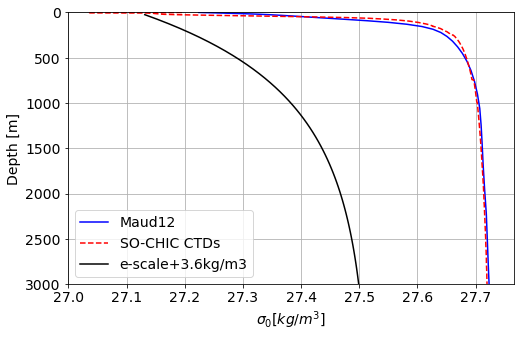

In [83]:
ylim=3000
fig,axes=plt.subplots(1,1,figsize=(8,5))
dst.sigma0_mean.plot(y="depth",ax=axes,label="Maud12",color="b")
dso.sigma0.mean("station").plot(y="depth",color="r",ax=axes,ls="--", label="SO-CHIC CTDs")
(dsbet.sigma0.where(dsbet.Temp>0).isel(T=0,Y=slice(1,-1)).mean(dim={"X","Y"})+3.6).plot(y="Z",ax=axes,color="k",label="e-scale+3.6kg/m3")
axes.set_ylim(0,ylim)
axes.invert_yaxis()
axes.grid()
axes.legend()
axes.set_ylabel('Depth [m]')
#axes[0].set_yticklabels('')
axes.set_title('')
axes.set_xlabel('$\\sigma_0 [kg/m^3]$')

